# Stroke Prediction
This notebook works through a project that aims to predict stroke in patients.

## Imports

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import matplotlib.ticker as ticker
import lightgbm as lgbm
from cycler import cycler
import scipy
import os
import sys

In [118]:
print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Seaborn version: {sns.__version__}")

Python version: 3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
pandas version: 1.5.3
matplotlib version: 3.6.3
NumPy version: 1.24.1
SciPy version: 1.10.0
Seaborn version: 0.12.2


In [119]:
# Matplotlib config


def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#0a84ff', '#ff9f0a', '#30d158', '#ff453a', '#bf5af2', '#5e5ce6', '#ff375f', '#64d2ff', '#ffd60a']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
white_color = '#d1d1d6'

palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': grey_palette[-2],
    'figure.edgecolor': grey_palette[-2],
    'axes.facecolor': grey_palette[-2],
    'text.color':white_color,
    'axes.labelcolor':white_color,
    'axes.edgecolor':white_color,
    'xtick.color':white_color,
    'ytick.color':white_color,
    'figure.dpi':150,
}

sns.set_theme(
    style='ticks',
    palette=sns.color_palette(palette),
    rc=custom_params
)



## EDA

In [120]:
train_df = pd.read_csv(r'dataset\playground-series-s3e2\train.csv')
test_df = pd.read_csv(r'dataset\playground-series-s3e2\train.csv')
features = test_df.columns

train_df.head()

print('-----Missing Values-----')
print(train_df.isnull().sum())

print('\n')
print('-----Classes-----')
display(pd.merge(
    train_df.stroke.value_counts().rename('count'),
    train_df.stroke.value_counts(True).rename('%').mul(100),
    left_index=True,
    right_index=True
))

-----Missing Values-----
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


-----Classes-----


,count,%
0,14672,95.870361
1,632,4.129639


In [121]:
train_df.duplicated().sum()

0

The above results show that there are no null or duplicate values, so it's safe to continue with the initial EDA.

In [138]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = [
    'gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type',
    'Residence_type', 'smoking_status'
]
target = 'stroke'
print(f'Numerical Columns: {numerical_cols}')
print(f'Categorical Columns: {categorical_cols}')

Numerical Columns: ['age', 'avg_glucose_level', 'bmi']
Categorical Columns: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


### Plots

In [139]:
train_df_plot = pd.crosstab(
    train_df['stroke'],
    columns='count'
)
train_df_plot = train_df_plot.reset_index()
train_df_plot = train_df_plot.sort_values('count', ascending=False)

Text(0.5, 1.0, 'Class Distribution')

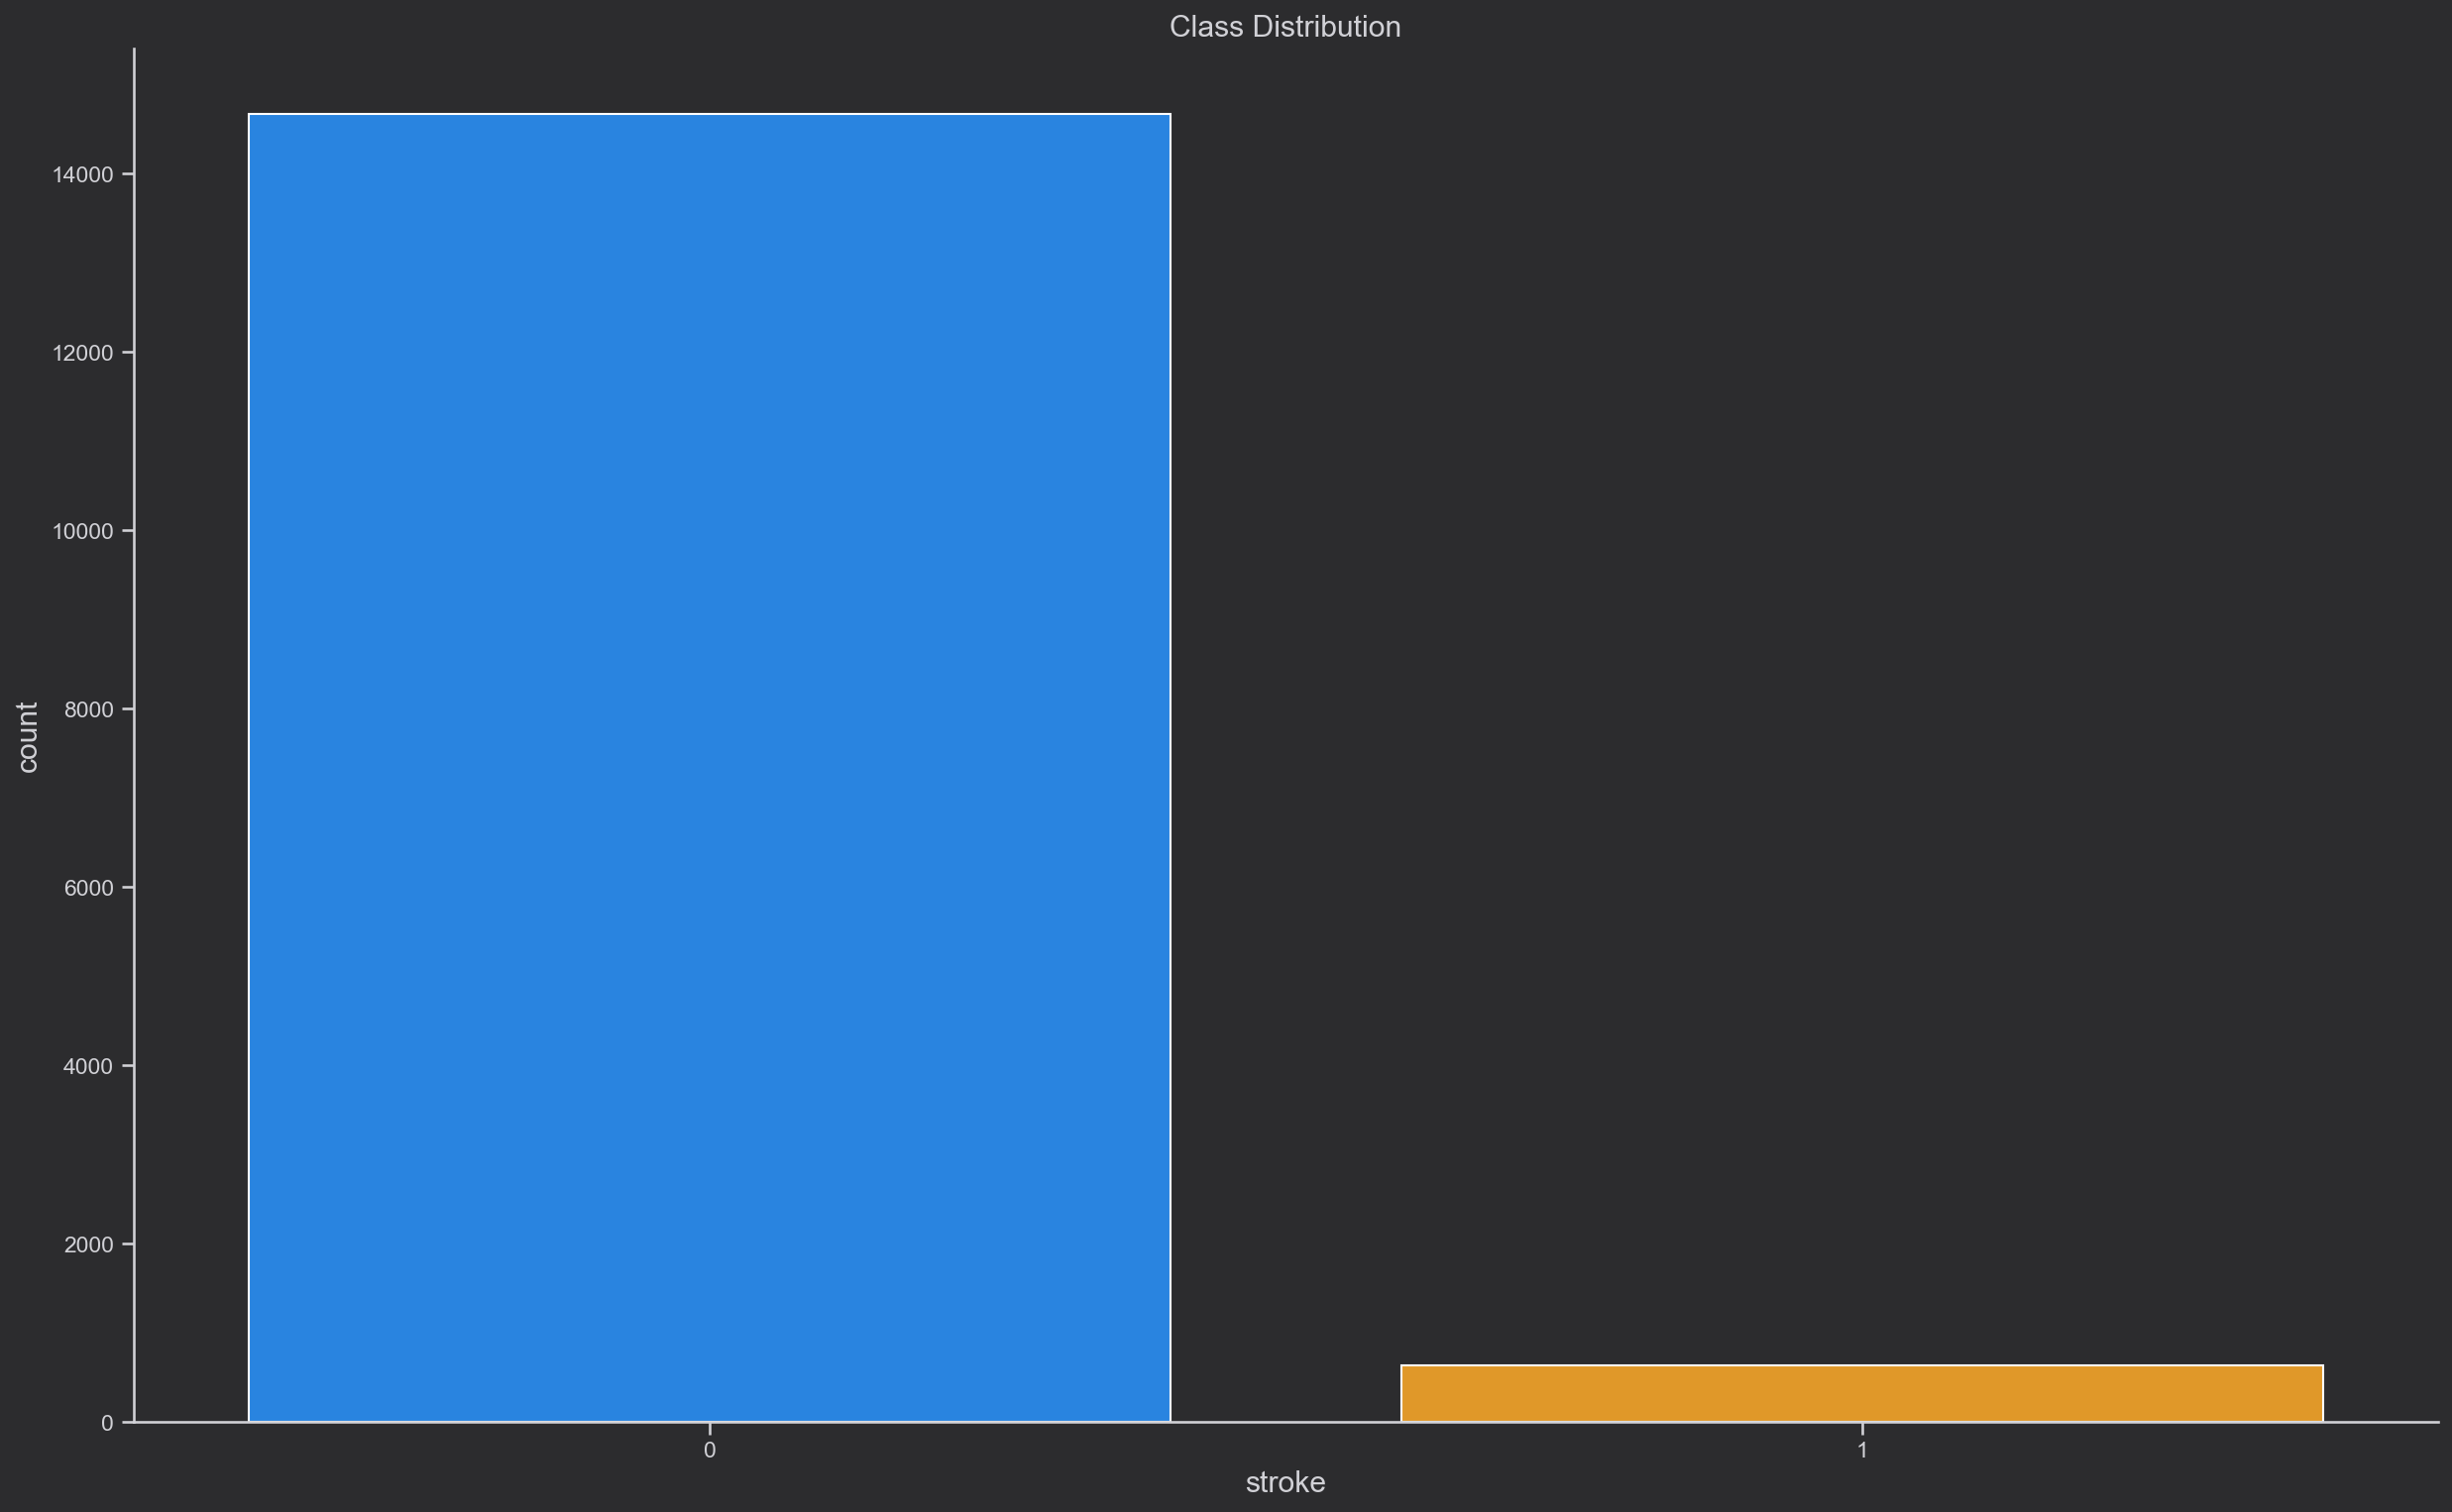

In [140]:
fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(
    data=train_df_plot,
    x='stroke', y='count',
    ax=ax
)
ax.set_title(f'Class Distribution')

As can be seen, the classes are very unevenly distributed. To alleviate it, SMOTE could be looked into to synthesise new data for the minority class (Stroke=1), however this introduces additional error. The best way to combat this would be to ensure that the data is split in a stratified manner when splitting into train_df/train_df sets.

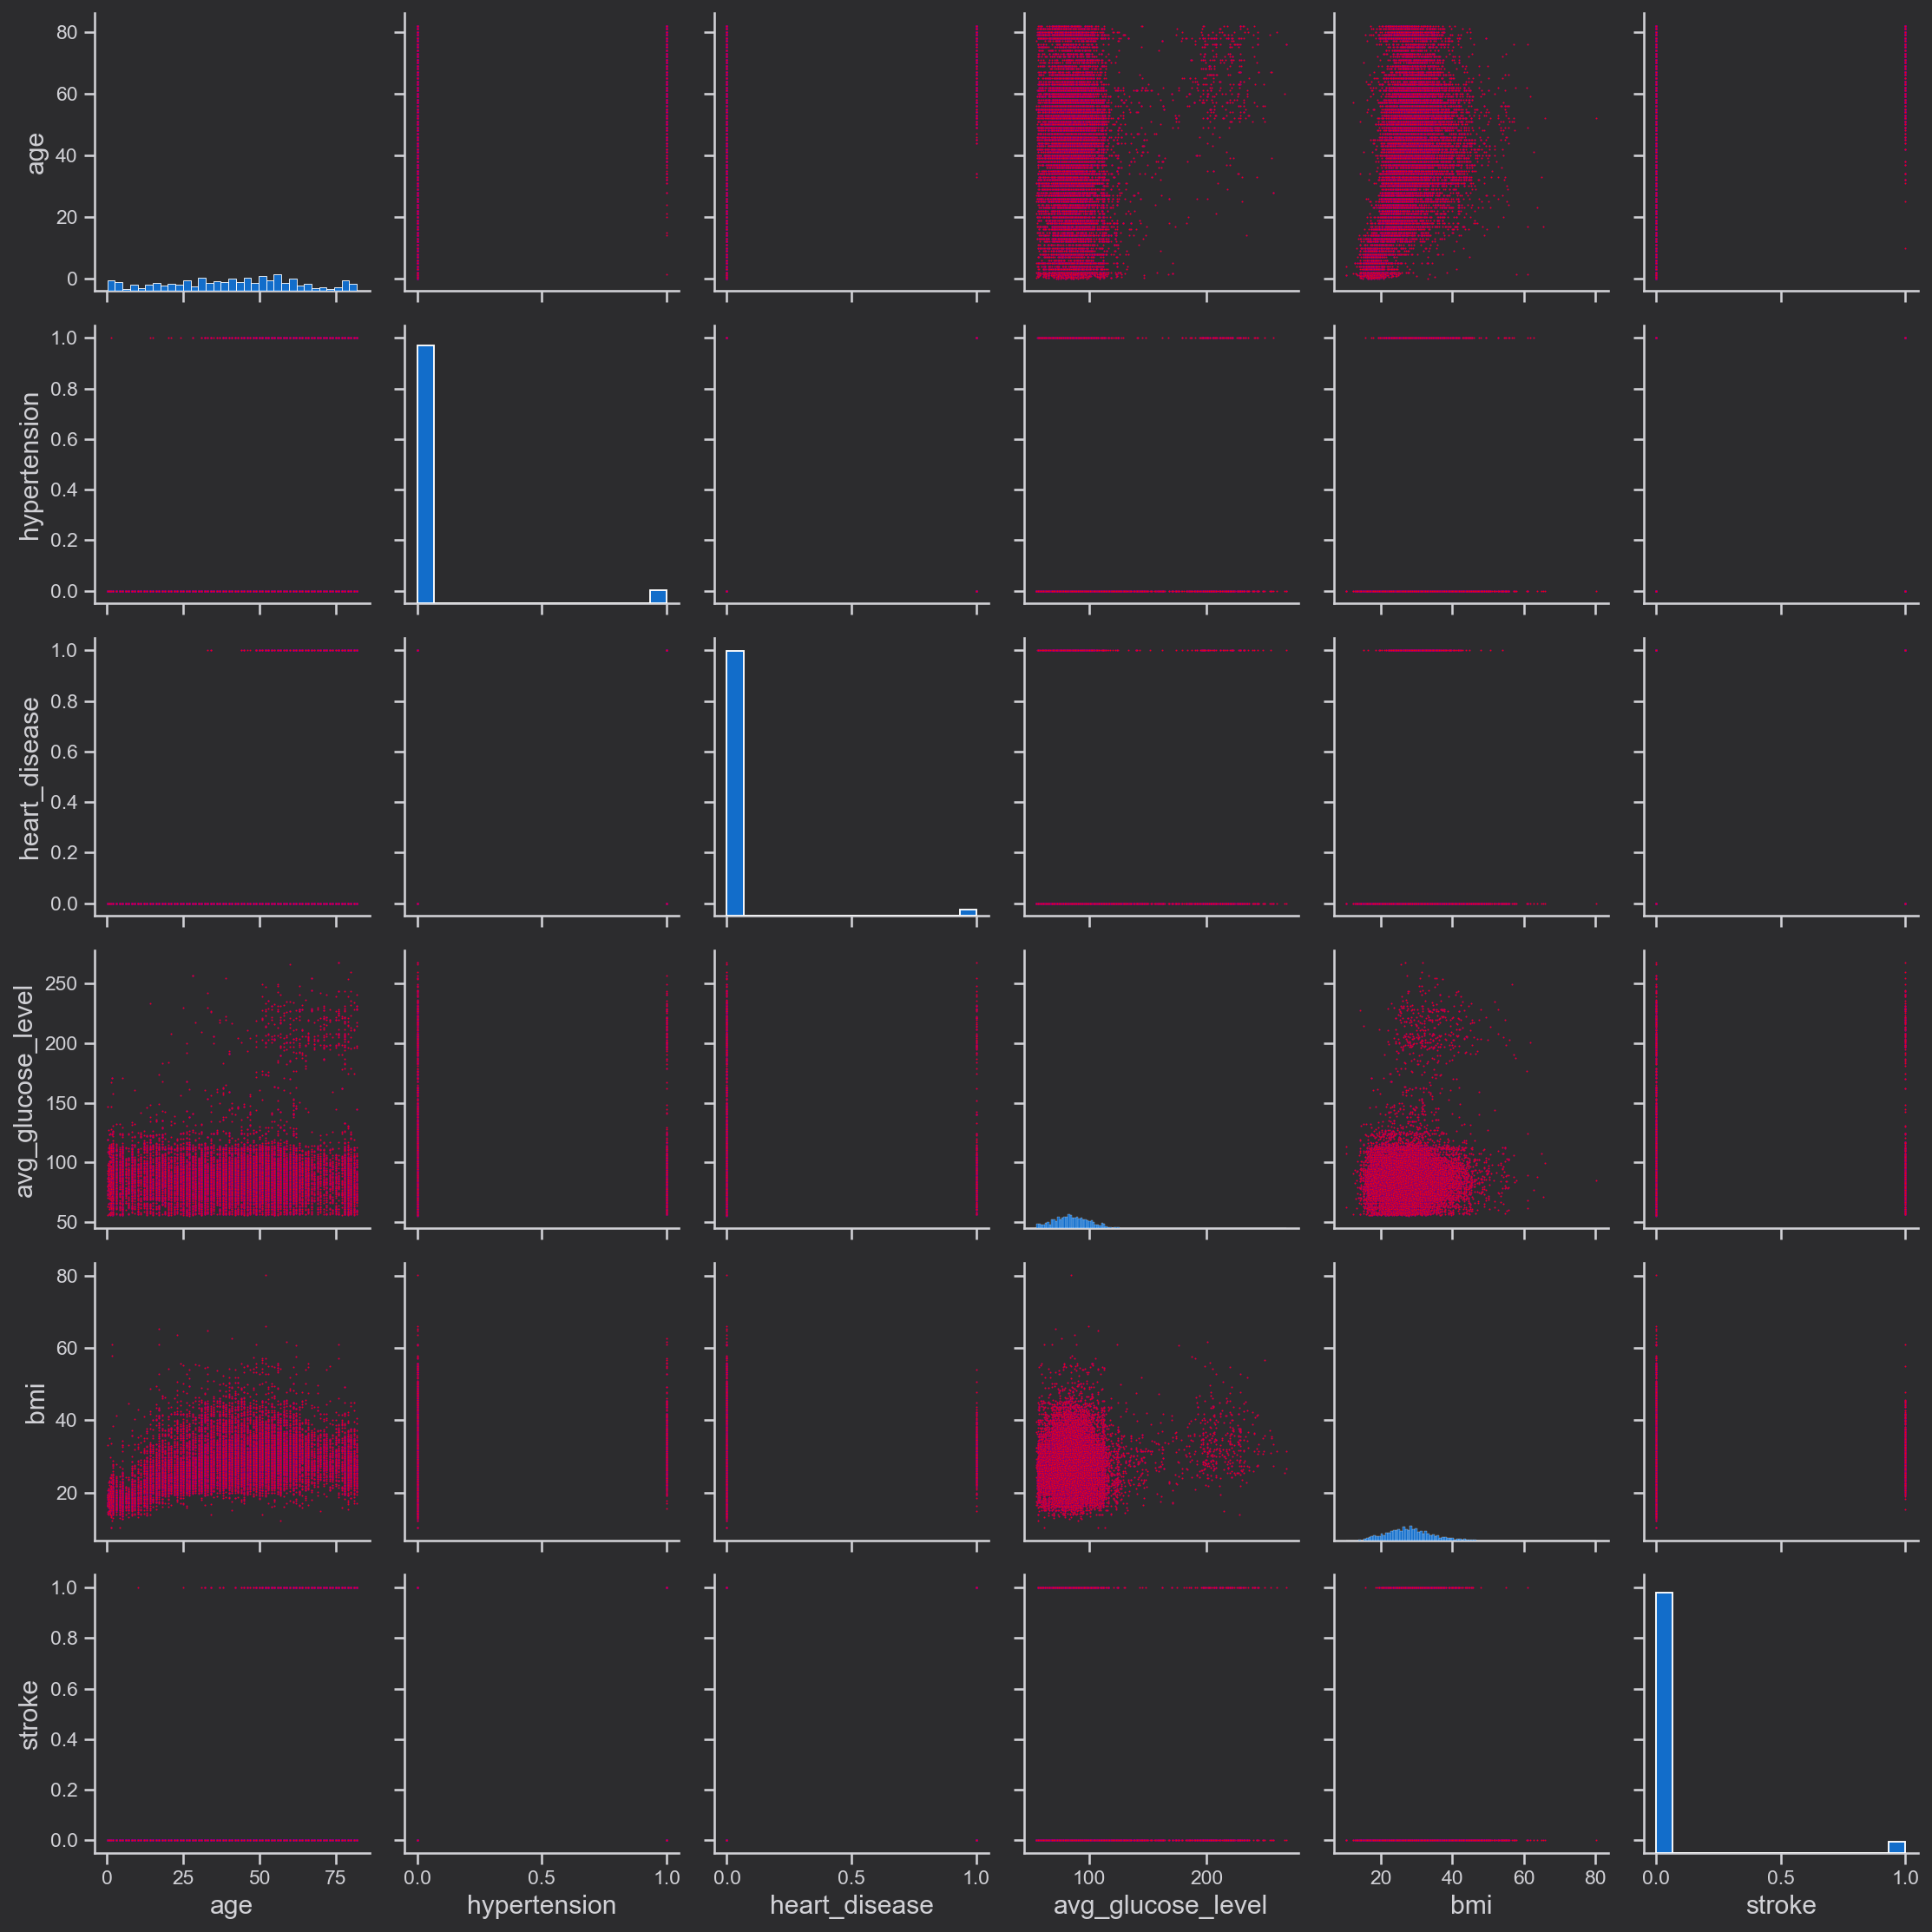

In [141]:
sns.pairplot(
    train_df.loc[:, train_df.columns != 'id'],
    diag_kind='hist',
    plot_kws={'facecolor': 'r', 'edgecolor': 'b', 's': 1}
)

plt.tight_layout()

There are a few obvious correlations visible from the pairplot, namely:
- Higher age correlates to higher heart disease rate
- Higher age correlates to higher stroke rate
- Age appears to have a roughly quadratic relationship with bmi
- High average glucose level appears to be more common in people of a higher age

In [142]:
# auxiliary function to plot mean of target
def plot_secondary(
    df, column, target_column, ax, n_bins, color=3,
    show_yticks=False,
):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker='.', color=colors[color], label=f'Mean {target_column}'
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


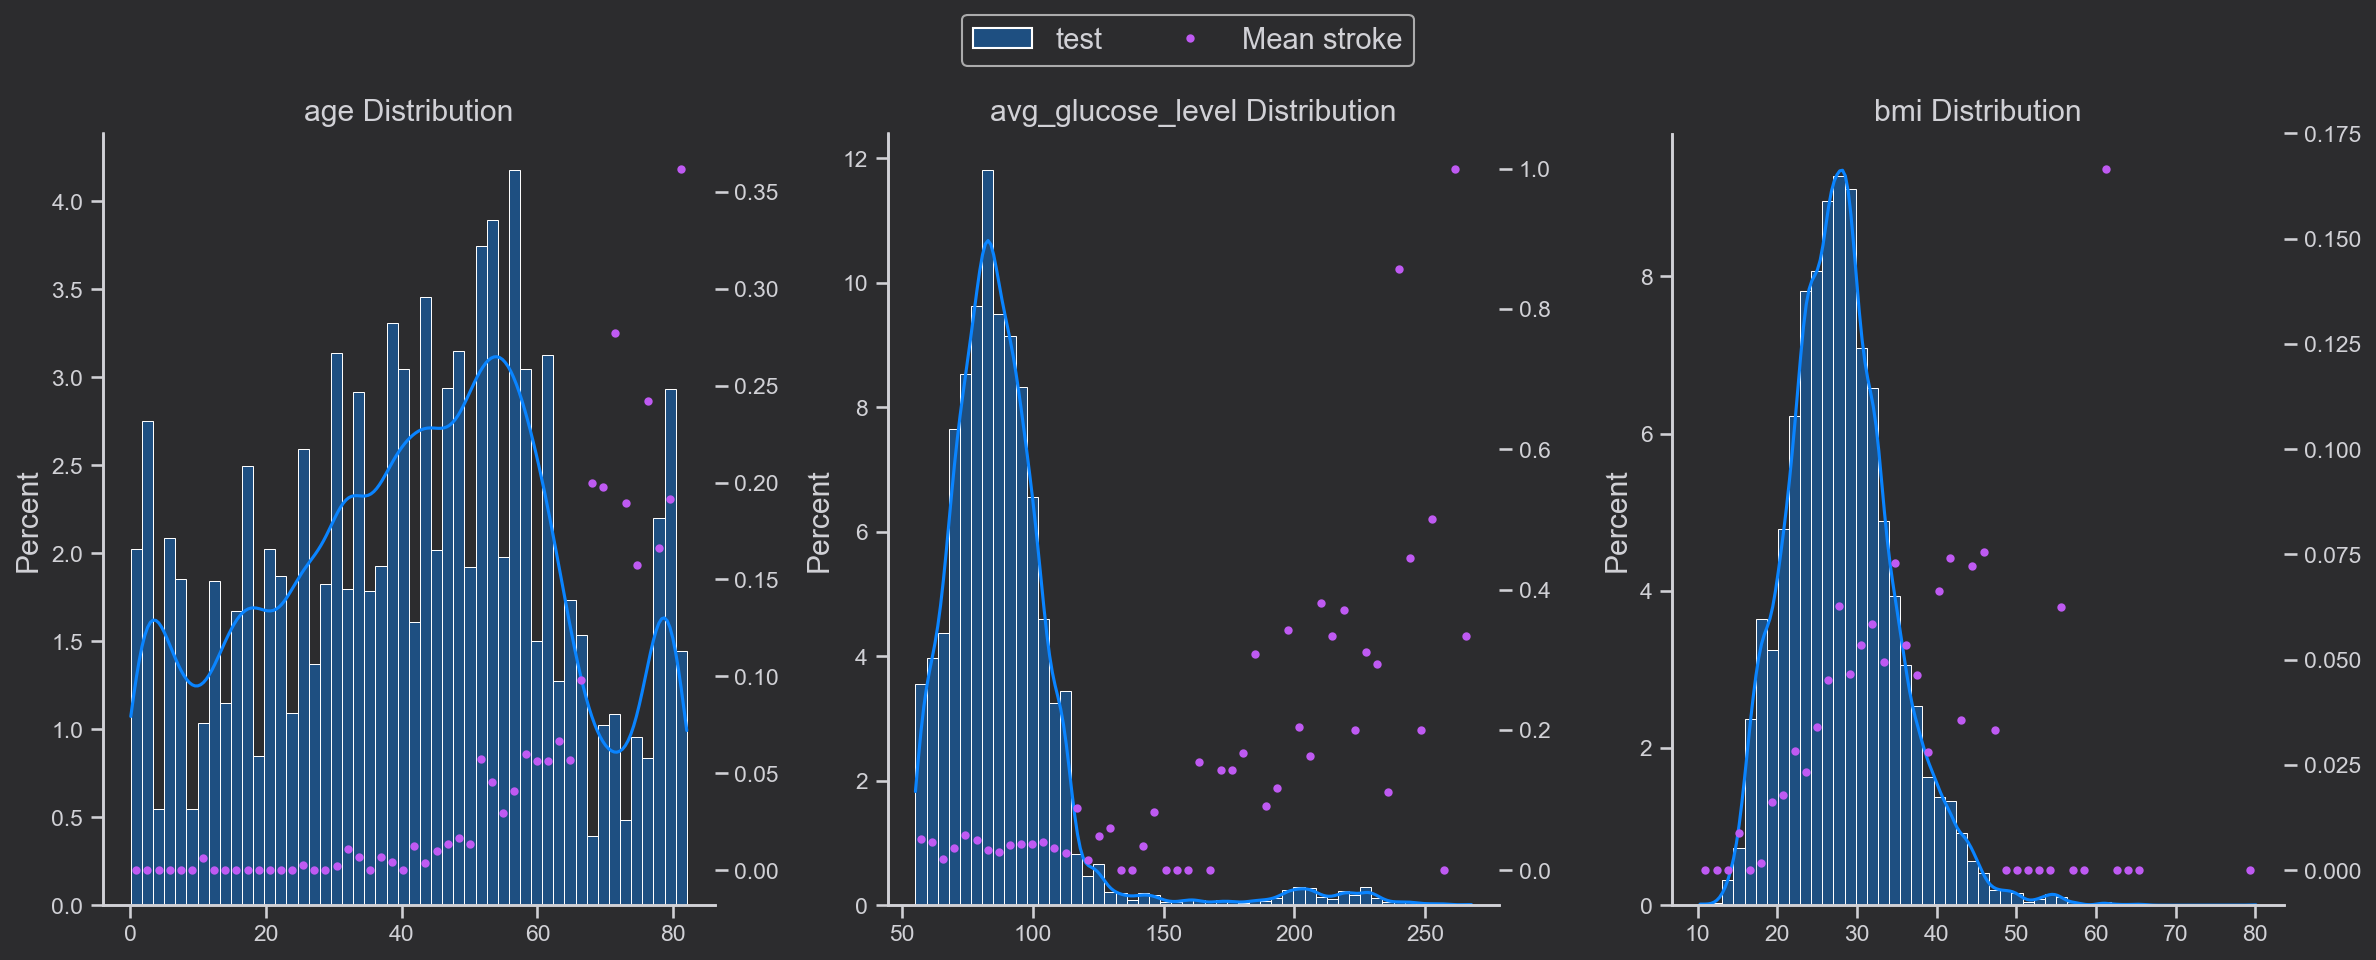

In [143]:
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

all_df = pd.concat([train_df, test_df])
all_df['set'] = 'train'
all_df.loc[all_df.index.isin(test_df.index), 'set'] = 'test'

columns = numerical_cols
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.histplot(
        data=all_df,
        x=column,
        hue='set',
        common_norm=False,
        ax=ax[i],
        **histplot_hyperparams
    )
    
    # Secondary axis to show mean of target
    ax2 = plot_secondary(train_df, column, 'stroke', ax[i], n_bins, color=4, show_yticks=True)
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove legends to show only one at the end
    plot_axes = [ax[i], ax2]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
        plot_ax.legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=14, ncol=3)
plt.tight_layout()